In [1]:
import pyprob #https://github.com/probprog/pyprob #!pip install pyprob
from pyprob import Model 
from pyprob.distributions import Categorical, Uniform, Normal
import numpy as np
import torch
import cv2
from pyprob import PriorInflation, InferenceEngine, InferenceNetwork
import matplotlib.pyplot as plt

Cannot import dbm.gnu: No module named '_gdbm'


/Users/ryanmarten/anaconda3/lib/python3.8/site-packages/pyprob/util.py:327: UserWarning: Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.
  warnings.warn('Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.')


In [2]:
# pip install opencv-python

In [51]:
class ImagesGen(Model):
    def __init__(self, name='ImagesModel', opt = None):
        super().__init__(name=name)
        self.opt = opt

        self.height, self.width = 75, 75
        self.colors = [
            (0,0,255),##r
            (0,255,0),##g
            (255,0,0),##b
            (0,156,255),##o
            (128,128,128),##k
            (0,255,255)##y
            ]
        self.size = 5

    def forward(self):
        # Initialize images with 255 (white background)
        img = np.ones((self.height,self.width, 3), dtype=np.uint8)*255
        objects = []
        for color_id,color in enumerate(self.colors):  
            center = self.center_generate(objects)
            shape = pyprob.sample(Categorical(probs=[0.5,0.5]), name=f"{color_id}_shape").item()
            if shape:
                start = (center[0]-self.size, center[1]-self.size)
                end = (center[0]+self.size, center[1]+self.size)
                cv2.rectangle(img, start, end, color, -1)
                objects.append((color_id,center,'r'))
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center_, self.size, color, -1)
                objects.append((color_id,center,'c'))

        rendered_img = torch.tensor(img).view(-1) # I had to add this for some reason --> check if it is right
        pyprob.tag(rendered_img, name="rendered_image")
        
        #Use VAE encoded represenation
        # encoded_mu, encoded_sigma = encoder(rendered_img)
        # pyprob.observe(Normal(encoded_mu, encoded_sigma), name="observed_image")
        pyprob.observe(Normal(rendered_img, 1), name="observed_image")
        
        # return the latent quantity of interest
        return objects

    def center_generate(self, objects):
        while True:
            pas = True
            center_x = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_x").item()
            center_y = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_y").item()
            #self.np.random.randint(0+size, img_size - size, 2)        
            center = torch.tensor([center_x, center_y])
            if len(objects) > 0:
                for name,c,shape in objects:
                    if torch.sum(((center - c) ** 2)) < ((self.size * 2) ** 2):
                        pas = False
            if pas:
                return center

In [89]:
def plot_trace(trace_image, title):
    img = np.array(trace_image.view(75,75, 3))
    img = img.astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(img)
    plt.show()

<ipython-input-89-86e24a039656>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


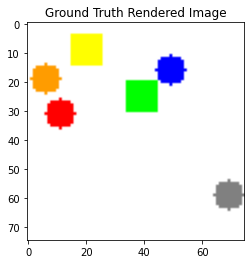

In [90]:
model = ImagesGen()
    
gt_trace = next(model._trace_generator(inference_engine=InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS))
plot_trace(gt_trace["rendered_image"], "Ground Truth Rendered Image")

In [54]:
gt_trace["rendered_image"]

tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

In [55]:
model.forward()

[(0, tensor([63, 50]), 'c'),
 (1, tensor([32, 11]), 'r'),
 (2, tensor([30, 21]), 'r'),
 (3, tensor([15, 63]), 'c'),
 (4, tensor([34, 39]), 'r'),
 (5, tensor([69, 34]), 'c')]

In [56]:
model = ImagesGen()
model.learn_inference_network(num_traces=500,
                              observe_embeddings={'observed_image' : {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable observed_image: reshape not specified, using shape torch.Size([16875]).
Observable observed_image: using embedding dim torch.Size([32]).
Observable observed_image: observe embedding not specified, using the default FEEDFORWARD.
Observable observed_image: embedding depth not specified, using the default 2.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 76__forward__center_generate__?__Categorical(len_p..., distribution: Categorical
New layers, address: 156__forward__center_generate__?__Categorical(len_..., distribution: Categorical
New layers, address: 88__forward__?__Categorical(len_probs:2)__1, distribution: Categorical
New layers, address: 76__forward__center_generate__?__Categorical(len_p..., distribution: Categorical
New layers, address: 156__forward__center_generate__?__Categorical(len_..., distribution: Categorical
New layers

In [57]:
# sample from posterior (500 samples)
posterior_results = model.posterior_results(
         num_traces=500, # the number of samples estimating the posterior
         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
         observe={'observed_image' : gt_trace["rendered_image"]} # assign values to the observed values
         )

Time spent  | Time remain.| Progress             | Trace   | ESS   | Traces/sec


/Users/ryanmarten/anaconda3/lib/python3.8/site-packages/pyprob/nn/inference_network_lstm.py:112: UserWarning: Address of current variable unknown by inference network: 76__forward__center_generate__?__Categorical(len_probs:70)__14
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/Users/ryanmarten/anaconda3/lib/python3.8/site-packages/pyprob/nn/inference_network_lstm.py:133: UserWarning: Using prior. No proposal for address: 76__forward__center_generate__?__Categorical(len_probs:70)__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/Users/ryanmarten/anaconda3/lib/python3.8/site-packages/pyprob/nn/inference_network_lstm.py:103: UserWarning: Address of previous variable unknown by inference network: 76__forward__center_generate__?__Categorical(len_probs:70)__14
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/Users/ryanmarten/anaconda3/lib/pyth

0d:00:00:14 | 0d:00:00:00 | #################### | 500/500 |  1.00 | 34.55       


In [101]:
[result for result in posterior_results]

[[(0, tensor([33, 53]), 'r'),
  (1, tensor([43, 17]), 'r'),
  (2, tensor([37, 39]), 'r'),
  (3, tensor([17, 16]), 'r'),
  (4, tensor([29, 69]), 'r'),
  (5, tensor([58, 14]), 'r')],
 [(0, tensor([12, 33]), 'r'),
  (1, tensor([22, 42]), 'c'),
  (2, tensor([ 8, 53]), 'c'),
  (3, tensor([57, 23]), 'r'),
  (4, tensor([19,  7]), 'r'),
  (5, tensor([39,  9]), 'c')],
 [(0, tensor([28, 68]), 'r'),
  (1, tensor([ 5, 45]), 'r'),
  (2, tensor([57, 34]), 'c'),
  (3, tensor([48, 57]), 'c'),
  (4, tensor([35, 54]), 'r'),
  (5, tensor([18,  2]), 'c')],
 [(0, tensor([31, 56]), 'r'),
  (1, tensor([2, 4]), 'r'),
  (2, tensor([10, 68]), 'r'),
  (3, tensor([39, 20]), 'c'),
  (4, tensor([10, 28]), 'c'),
  (5, tensor([50, 63]), 'c')],
 [(0, tensor([60, 11]), 'r'),
  (1, tensor([34, 38]), 'r'),
  (2, tensor([32, 27]), 'c'),
  (3, tensor([34, 68]), 'c'),
  (4, tensor([ 6, 51]), 'r'),
  (5, tensor([51, 55]), 'c')],
 [(0, tensor([26, 20]), 'c'),
  (1, tensor([48, 18]), 'r'),
  (2, tensor([16, 43]), 'r'),
  (3, t

In [58]:
posterior_unweighted = posterior_results.unweighted()

In [67]:
posterior_results.sample()

[(0, tensor([59, 29]), 'r'),
 (1, tensor([35, 21]), 'c'),
 (2, tensor([66, 58]), 'c'),
 (3, tensor([61,  2]), 'r'),
 (4, tensor([44,  2]), 'c'),
 (5, tensor([56, 45]), 'r')]

In [62]:
posterior_unweighted[1]

[(0, tensor([12, 33]), 'r'),
 (1, tensor([22, 42]), 'c'),
 (2, tensor([ 8, 53]), 'c'),
 (3, tensor([57, 23]), 'r'),
 (4, tensor([19,  7]), 'r'),
 (5, tensor([39,  9]), 'c')]

In [68]:
colors = [
            (0,0,255),##r
            (0,255,0),##g
            (255,0,0),##b
            (0,156,255),##o
            (128,128,128),##k
            (0,255,255)##y
            ]

In [74]:
size = 5
height = 75
width = 75

In [95]:
def render_from_latents(objects):
        img = np.ones((height,width, 3), dtype=np.uint8)*255
        for obj in objects:  
            center = (obj[1][0].item(), obj[1][1].item())
            shape = obj[2]
            color = colors[obj[0]]
            if shape == "r":
                start = (center[0]-size, center[1]-size)
                end = (center[0]+size, center[1]+size)
                cv2.rectangle(img, start, end, color, -1)
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center, size, color, -1)
        return torch.tensor(img).view(-1)

In [96]:
rendered_posterior_sample = render_from_latents(posterior_results[1])
rendered_posterior_sample

tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

<ipython-input-89-86e24a039656>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


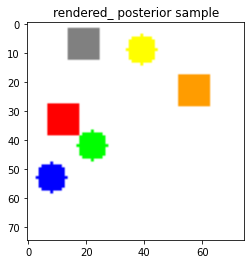

In [98]:
plot_trace(rendered_posterior_sample, "rendered_ posterior sample")

In [102]:
# guess.. instead of returning the objects, we return the VAE encoded vector. then these are continuous real numbers 
# that are weighted for importance sampling. We are calc the likelihood under Normal(mu=encoded_vector)
# then we are able to decode from the weighted samples to get the final inferred image? 